In [1]:
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import gym

In [19]:
import time
import numpy as np

# Define visual experiment
def init_fig(env):
    plt.figure()
    plt.title(f"{env.spec.id} | Episode: 0 | Step: 0 | Reward: 0.0")
    plt.axis('off')
    return plt.imshow(env.render(mode='rgb_array'))

def update_fig(img, env, episode, step, total_reward, done):
    plt.title(f"{env.spec.id} | Episode: {episode} | Step: {step} | Reward: {total_reward} | Done: {done}")
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

def visual_experiment(env, next_action, max_episode_steps=100, max_episodes=3, visualize_in_notebook=True, sleep=0.01):
    episode_rewards = []
    env.reset()

    # initialize figure in notebook
    if visualize_in_notebook:
        img = init_fig(env)

    for episode in range(1, max_episodes+1):
        # reset env
        time.sleep(1)
        obs = env.reset()
        total_reward = 0.0
        
        for step in range(1, max_episode_steps+1):
            action = next_action(obs)
            obs, reward, done, info = env.step(action)
            total_reward += reward
            
            if visualize_in_notebook:
                update_fig(img, env, episode, step, total_reward, done)
            else:
                env.render()
            
            if sleep > 0.0:
                time.sleep(sleep)

        episode_rewards.append(total_reward)

    print(f"Rewards: {episode_rewards}")
    print(f"Mean reward of {len(episode_rewards)} episodes: {np.mean(episode_rewards)}")
    print(f"Std reward of {len(episode_rewards)} episodes: {np.std(episode_rewards)}")

In [25]:
def experiment(env, next_action, max_episode_steps=100, max_episodes=3):
    episode_rewards = []
    episode_obs_records = []
    env.reset()

    for episode in range(1, max_episodes+1):
        # reset env
        obs = env.reset()
        total_reward = 0.0
        obs_records = [obs]
        
        for step in range(1, max_episode_steps+1):
            action = next_action(obs)
            obs, reward, done, info = env.step(action)
            total_reward += reward
            obs_records.append(obs)

        episode_rewards.append(total_reward)
        episode_obs_records.append(obs_records)

    return np.array(episode_rewards), np.array(episode_obs_records)

### Run the env by randoming sampling an action

Rewards: [26.0, 29.0, 32.0]
Mean reward of 3 episodes: 29.0
Std reward of 3 episodes: 2.449489742783178


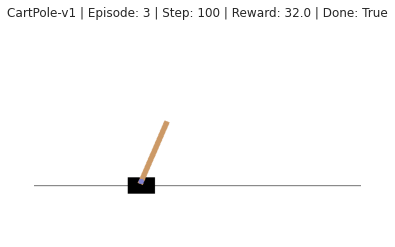

In [130]:
# Run the env by randoming sampling an action
env = gym.make('CartPole-v1')
_ = visual_experiment(env, lambda obs: env.action_space.sample(), sleep=0)

In [142]:
rewards, records = experiment(env, lambda obs: env.action_space.sample(), max_episode_steps=500, max_episodes=10)

/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


In [253]:
import pandas as pd
import seaborn as sns

sns.set_style("white", {'axes.spines.right': False, 'axes.spines.top': False})
# sns.set(font_scale=1.2)

def visualize_obs(records):
    if len(records) > 10:
        records = records[np.random.choice(len(records), size=10, replace=False)]
    
    num_episodes = len(records)
    pos_data = pd.DataFrame(records[:, :, 0].T, columns=[f'Ep. {i}' for i in range(1, num_episodes+1)])
    angle_data = pd.DataFrame(records[:, :, 2].T, columns=[f'Ep. {i}' for i in range(1, num_episodes+1)])
    
    _, (pos_ax, angle_ax) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
#     sns.barplot(data=reward_data, ax=axs[0]).set(xlabel="Episode", ylabel="Rewards")

    sns.lineplot(data=pos_data, ax=pos_ax).set(xlabel="Step", ylabel="Position")
#     pos_ax.legend(bbox_to_anchor=(1.35, 0), loc='lower right')
    
    sns.lineplot(data=angle_data*180/np.pi, ax=angle_ax).set(xlabel="Step", ylabel="Angle")
#     angle_ax.legend(bbox_to_anchor=(1.35, 1), loc='upper right')

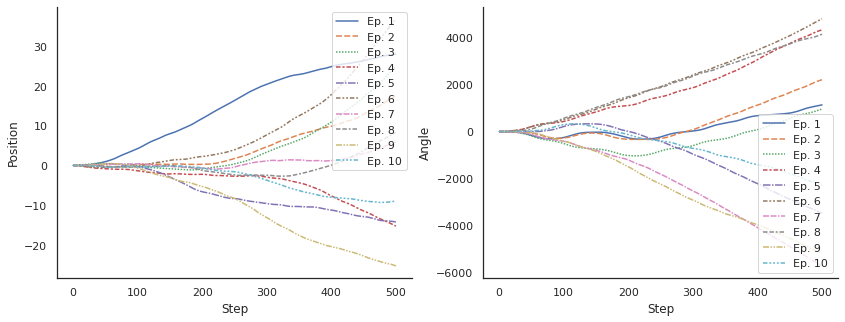

In [254]:
visualize_obs(records)

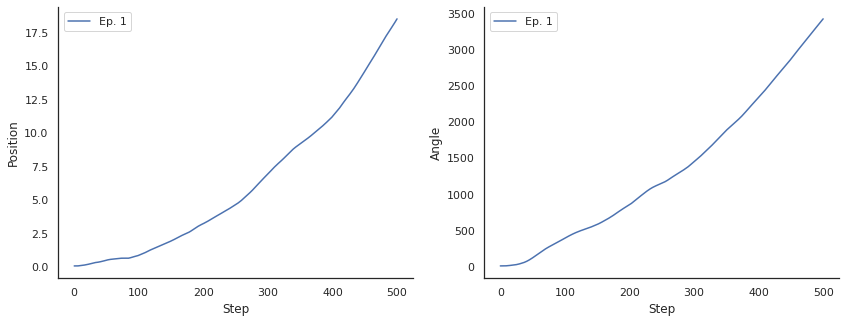

In [255]:
visualize_obs(np.abs(records).mean(axis=0, keepdims=True))

### Run the original env by a trained agent

In [213]:
from stable_baselines3 import PPO

model_ppo = PPO.load("best_model")
rewards1, records1 = experiment(env, lambda obs: model_ppo.predict(obs)[0], max_episode_steps=500, max_episodes=100)
env.close()

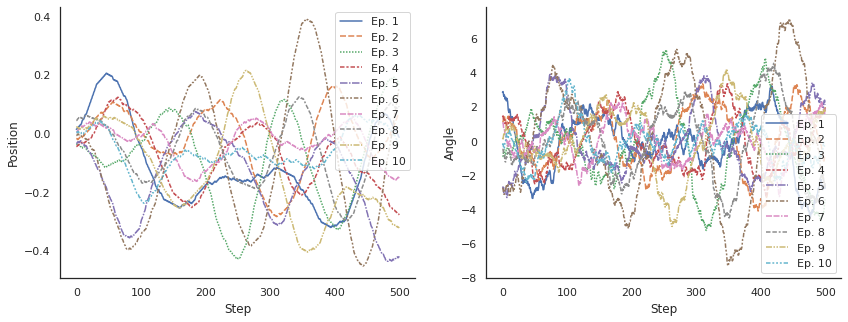

In [256]:
visualize_obs(records1)

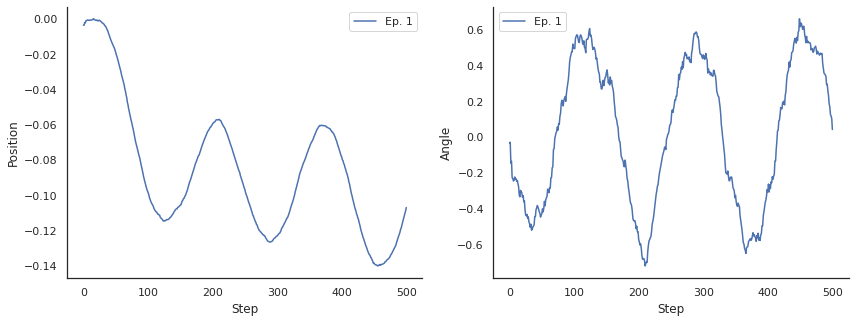

In [257]:
visualize_obs(records1.mean(axis=0, keepdims=True))

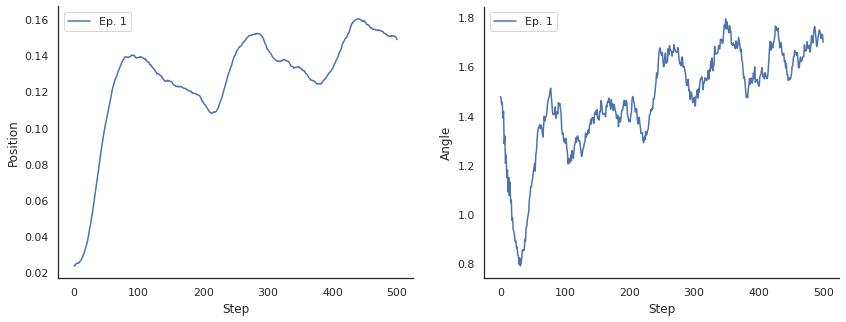

In [258]:
visualize_obs(np.abs(records1).mean(axis=0, keepdims=True))

### Create deviated environment

In [191]:
# Create a mutated environment
from gym.envs.classic_control import CartPoleEnv
from gym.wrappers.time_limit import TimeLimit
from types import SimpleNamespace

class MutatedCartPoleEnv(CartPoleEnv):
    def __init__(self, masscart = 1.0, masspole = 0.1, length = 0.5, force_mag = 10.0):
        super().__init__()
        
        self.spec = SimpleNamespace()
        self.spec.id = f"MutatedCartPole-{masscart}-{masspole}-{length}-{force_mag}"
        
        self.gravity = 9.8
        self.masscart = masscart
        self.masspole = masspole
        self.total_mass = self.masspole + self.masscart
        self.length = length  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02  # seconds between state updates

In [220]:
mutated_env2 = MutatedCartPoleEnv(masscart=0.5)
rewards2, records2 = experiment(mutated_env2, lambda obs: model_ppo.predict(obs)[0], max_episode_steps=500, max_episodes=100)
mutated_env2.close()

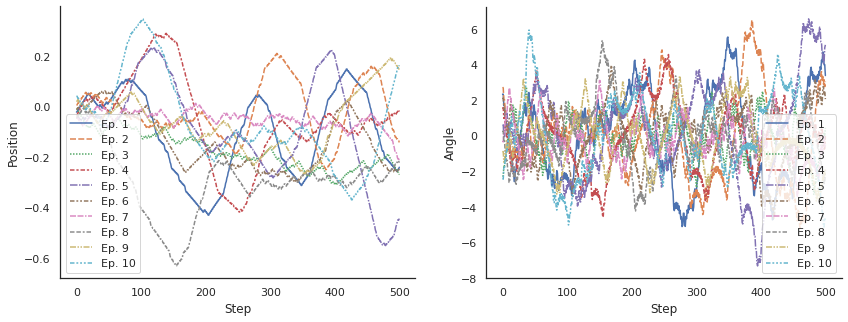

In [259]:
visualize_obs(records2)

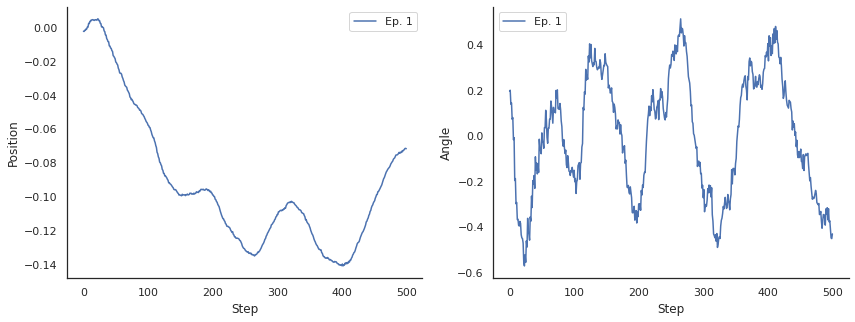

In [260]:
visualize_obs(records2.mean(axis=0, keepdims=True))

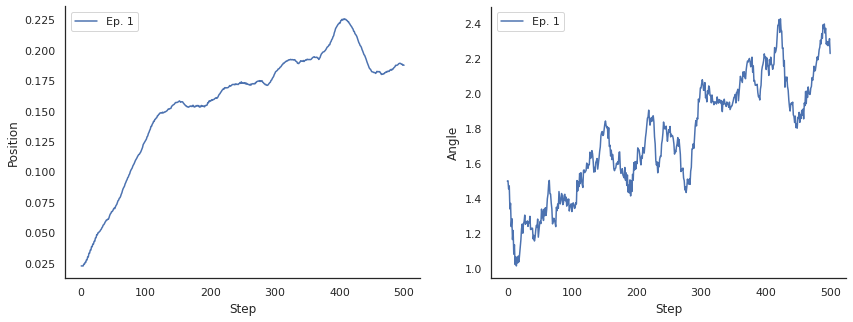

In [261]:
visualize_obs(np.abs(records2).mean(axis=0, keepdims=True))

In [227]:
mutated_env3 = MutatedCartPoleEnv(force_mag=20)
rewards3, records3 = experiment(mutated_env3, lambda obs: model_ppo.predict(obs)[0], max_episode_steps=500, max_episodes=100)
mutated_env3.close()

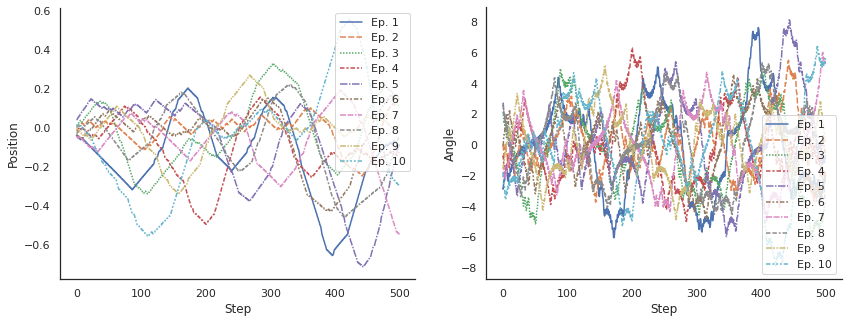

In [262]:
visualize_obs(records3)

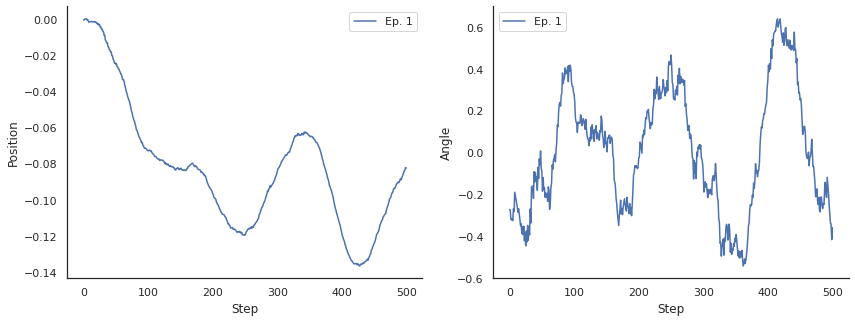

In [263]:
visualize_obs(records3.mean(axis=0, keepdims=True))

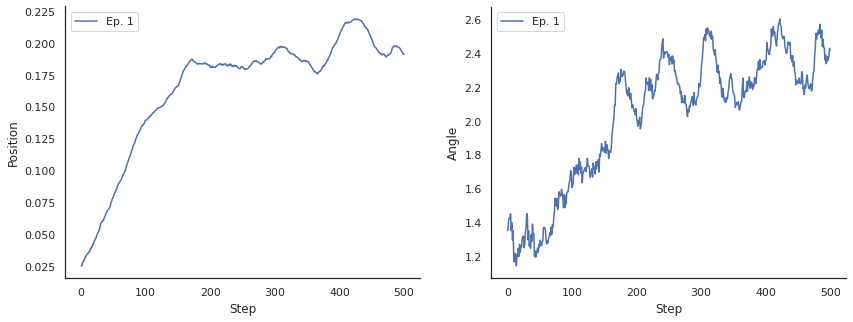

In [264]:
visualize_obs(np.abs(records3).mean(axis=0, keepdims=True))

### Use STL Robustness value

In [223]:
# Compute robustness value of the STL formula:
#   G ( pos > -2.4 & pos < 2.4 & angle > -12 degree & angle < 12 degree )
import signal_tl as stl

pos = stl.Predicate('pos')
angle = stl.Predicate('angle')

pos_threshold = 2.4
angle_threshold = 12 * 2 * np.pi / 360

phi = stl.Always(
    (pos > -pos_threshold) & (pos < pos_threshold) &\
    (angle > -angle_threshold) & (angle < angle_threshold)
)

def compute_STL_robustness(records):
    time_index = np.arange(records.shape[1])
    robs = []
    for i in range(len(records)):
        trace = {
            "pos": stl.Signal(records[i, :, 0], time_index),
            "angle": stl.Signal(records[i, :, 2], time_index)
        }
        rob = stl.compute_robustness(phi, trace)
        robs.append(rob.at(0))
    return np.array(robs)

In [231]:
num_episodes = len(records1)
robustness_data = pd.DataFrame(
    np.array([
        compute_STL_robustness(records1),
        compute_STL_robustness(records2),
        compute_STL_robustness(records3)
    ]).T,
    columns=["original", "masscart=0.5", "forcemag=20"],
    index=[f'Ep. {i}' for i in range(1, num_episodes+1)]
)
robustness_data.head()

,original,masscart=0.5,forcemag=20
Ep. 1,0.144017,0.120593,0.073743
Ep. 2,0.130104,0.133530,0.145376
Ep. 3,0.133304,0.104586,0.076668
Ep. 4,0.151121,0.110825,0.080169
Ep. 5,0.122224,0.098091,0.104539


In [232]:
robustness_data.describe()

,original,masscart=0.5,forcemag=20
count,100.000000,100.000000,100.000000
mean,0.137325,0.115161,0.105101
std,0.020881,0.024854,0.027183
min,0.070096,0.017461,0.025621
25%,0.128415,0.101438,0.082983
50%,0.139956,0.117847,0.108540
75%,0.152690,0.132108,0.125169
max,0.177904,0.152559,0.158437


<AxesSubplot:>

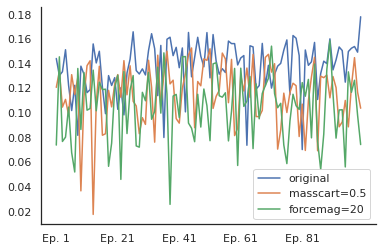

In [265]:
robustness_data.plot()

In [266]:
np.corrcoef(robustness_data['original'], robustness_data['masscart=0.5'])

array([[ 1.        , -0.09998622],
       [-0.09998622,  1.        ]])

In [267]:
np.corrcoef(robustness_data['original'], robustness_data['forcemag=20'])

array([[ 1.        , -0.09160298],
       [-0.09160298,  1.        ]])

In [268]:
from scipy.stats import pearsonr

pearsonr(robustness_data['original'], robustness_data['masscart=0.5'])

(-0.09998621780167224, 0.3222843950155923)

In [269]:
pearsonr(robustness_data['original'], robustness_data['forcemag=20'])

(-0.09160298154520312, 0.3647132274406593)